In [1]:
import pandas as pd
import numpy as np

# input is the merged CAMS and ERA5 data that were aggregated to country levels
input_path = "Climate_Data_Final.csv"
output_path = "Climate_Data_Final_with_units.csv"
df = pd.read_csv(input_path)

In [2]:
def add_monthly_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Additional, derived variables
    # --- Temperature: Kelvin -> Celsius ---
    df["t2m_C"] = df["t2m"] - 273.15
    df["d2m_C"] = df["d2m"] - 273.15
    df["skt_C"] = df["skt"] - 273.15

    # --- Wind speed from u10, v10 ---
    df["wind_speed"] = np.sqrt(df["u10"]**2 + df["v10"]**2)

    # --- Relative Humidity ---
    t = df["t2m_C"]
    td = df["d2m_C"]
    # Magnus formula            
    es = 6.112 * np.exp((17.67 * t) / (t + 243.5))     # saturation vapor pressure
    e = 6.112 * np.exp((17.67 * td) / (td + 243.5))    # actual vapor pressure

    df["relative_humidity"] = 100 * (e / es)


    # --- Pollution Unit Conversion (kg/m3 -> miu g/m3) ---
    pol_cols = ['pm2p5', 'pm10', 'tcco', 'tcno2', 'gtco3', 'tcso2']
    for col in pol_cols:
        if col in df.columns:
            df[col] = df[col] * 1e9

    # --- Precipitation Calculation (Rate -> Total) ---
    def get_days_in_month(row):
        if row['month'] in [1, 3, 5, 7, 8, 10, 12]:
            return 31
        elif row['month'] in [4, 6, 9, 11]:
            return 30
        elif row['month'] == 2:
            year = row['year']
            if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
                return 29
            return 28
        return 30

    days_in_month = df.apply(get_days_in_month, axis=1)
    
    # Rate (m/day) * 1000 (mm/m) * Days = Total (mm/month)
    df["tp"] = df["tp"] * 1000 * days_in_month


    df["temp_skin_minus_air"] = df["skt_C"] - df["t2m_C"]  # skin_temp - temp_C
    df["dewpoint_depression"] = df["t2m_C"] - df["d2m_C"]  # temp_C - dewpoint_C
    df["pressure_gradient"] = df["msl"] - df["sp"]         # msl_pressure - surface_pressure

    df["conv_precip_share"] = 0.0
    mask_rain = df["tp"] > 0                               # precip_total
    df.loc[mask_rain, "conv_precip_share"] = (
        df.loc[mask_rain, "cp"] / df.loc[mask_rain, "tp"]  # precip_conv / precip_total
    )
    df["conv_precip_share"] = df["conv_precip_share"].clip(0.0, 1.0)


    # Adding a season variable
    season_map = {
        12: "winter", 1: "winter", 2: "winter",
        3: "spring", 4: "spring", 5: "spring",
        6: "summer", 7: "summer", 8: "summer",
        9: "autumn", 10: "autumn", 11: "autumn",
    }
    df["month"] = df["month"].astype(int)
    # df["season"] = df["month"].map(season_map).astype("category")
    df.insert(loc = 3,
          column = 'season',
          value = df["month"].map(season_map).astype("category"))

    return df


df = add_monthly_features(df)
# df_monthly.to_csv(ROOT / "data_processed" / "monthly_with_features.csv", index=False)

In [3]:
# Now we rename some variables for better readability

rename_map = {
    "pm2p5": "pm25",
    "pm10": "pm10",
    "tcco": "co_column",
    "tcno2": "no2_column",
    "gtco3": "o3_column",
    "tcso2": "so2_column",

    "tp": "precip_total",
    "cp": "precip_conv",
    "lsp": "precip_ls",

    "ssrd": "solar_rad",
    "avg_sduvrf": "avg_uv_rad",

    "u10": "wind_u",
    "v10": "wind_v",
    "i10fg": "wind_gust",

    "t2m": "temp_K",
    "d2m": "dewpoint_K",
    "skt": "skin_temp_K",

    "t2m_C": "temp_C",
    "d2m_C": "dewpoint_C",
    "skt_C": "skin_temp_C",

    "msl": "msl_pressure",
    "sp": "surface_pressure",
}

df = df.rename(columns=rename_map)
# df.head()

In [4]:
# SANITY CHECKS

# 1. Basic info
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# 2. Missingness
missing_by_col = df.isna().mean().sort_values(ascending=False)
print("\n% missing by column (top 20):\n", missing_by_col.head(20))


Shape: (95568, 32)
Columns: ['country_name', 'year', 'month', 'season', 'precip_total', 'avg_uv_rad', 'precip_conv', 'precip_ls', 'solar_rad', 'wind_gust', 'wind_u', 'wind_v', 'dewpoint_K', 'temp_K', 'surface_pressure', 'msl_pressure', 'skin_temp_K', 'pm25', 'pm10', 'co_column', 'no2_column', 'o3_column', 'so2_column', 'temp_C', 'dewpoint_C', 'skin_temp_C', 'wind_speed', 'relative_humidity', 'temp_skin_minus_air', 'dewpoint_depression', 'pressure_gradient', 'conv_precip_share']

% missing by column (top 20):
 no2_column          0.522727
co_column           0.522727
o3_column           0.522727
so2_column          0.522727
pm10                0.522727
pm25                0.522727
country_name        0.000000
year                0.000000
solar_rad           0.000000
wind_gust           0.000000
month               0.000000
season              0.000000
precip_total        0.000000
avg_uv_rad          0.000000
precip_conv         0.000000
precip_ls           0.000000
msl_pressure        0

In [5]:

# 3. Duplicate key rows
dups = df.duplicated(subset=["country_name", "year", "month"], keep=False)
print("\nDuplicate (country,year,month) rows:", dups.sum())
if dups.any():
    print(df.loc[dups, ["country_name", "year", "month"]].head())



Duplicate (country,year,month) rows: 0


In [6]:

# 4. Counts per country-year
counts = df.groupby(["country_name", "year"]).size().rename("n_months")
print("\nExample counts per country-year (value counts):\n", counts.value_counts().sort_index())



Example counts per country-year (value counts):
 n_months
12    7964
Name: count, dtype: int64


In [8]:
# PCA ANALYSIS

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Separate variable lists
meteo_vars = [
    "temp_C", "solar_rad", "avg_uv_rad", 
    "relative_humidity", "dewpoint_depression",
    "precip_total", "conv_precip_share",
    "wind_speed", "wind_gust",
    "msl_pressure", "pressure_gradient"
]


pollution_vars = ["pm25", "pm10", "no2_column", "o3_column", "so2_column", "co_column"]

# --- TRACK 1: METEOROLOGY (Full Timeline) ---
df_met_input = df[meteo_vars].dropna()
scaler_met = StandardScaler()  # standardize and scale first!!!
X_met_scaled = scaler_met.fit_transform(df_met_input)

pca_met = PCA(n_components=5)
X_met_pca = pca_met.fit_transform(X_met_scaled)

# --- TRACK 2: POLLUTION (2003-2023 Only) ---
df_pol_input = df[pollution_vars].dropna() 
scaler_pol = StandardScaler()
X_pol_scaled = scaler_pol.fit_transform(df_pol_input)

pca_pol = PCA(n_components=3) 
X_pol_pca = pca_pol.fit_transform(X_pol_scaled)

In [9]:
# --- METEO LOADINGS ---
print("Meteorology Explained Variance:")
for i, ev in enumerate(pca_met.explained_variance_ratio_):
    print(f"PC_Met_{i+1}: {ev:.3f}")

loadings_meteo = pd.DataFrame(
    pca_met.components_.T,
    index=meteo_vars,
    columns=[f"PC_Met_{i+1}" for i in range(pca_met.n_components_)]
)
display(loadings_meteo)

# --- POLLUTION LOADINGS ---
print("\nPollution Explained Variance:")
for i, ev in enumerate(pca_pol.explained_variance_ratio_):
    print(f"PC_Pol_{i+1}: {ev:.3f}")

loadings_pollution = pd.DataFrame(
    pca_pol.components_.T,
    index=pollution_vars,
    columns=[f"PC_Pol_{i+1}" for i in range(pca_pol.n_components_)]
)
display(loadings_pollution)

Meteorology Explained Variance:
PC_Met_1: 0.386
PC_Met_2: 0.202
PC_Met_3: 0.173
PC_Met_4: 0.077
PC_Met_5: 0.071


,PC_Met_1,PC_Met_2,PC_Met_3,PC_Met_4,PC_Met_5
temp_C,0.400191,0.290115,0.120678,-0.133199,0.065791
solar_rad,0.447613,0.032797,-0.044997,0.246169,0.187761
avg_uv_rad,0.439061,0.101243,-0.026085,0.283393,0.197855
relative_humidity,-0.319061,0.434173,0.194197,0.103474,0.202804
dewpoint_depression,0.343163,-0.379323,-0.145324,-0.131803,-0.282272
precip_total,-0.102263,0.551669,-0.013014,0.304968,-0.188543
conv_precip_share,0.371148,0.207396,-0.052149,-0.179316,0.318429
wind_speed,0.111005,-0.114649,0.630456,0.196118,0.197344
wind_gust,-0.032503,-0.348910,0.520779,0.375567,-0.104116
msl_pressure,-0.248414,-0.263131,-0.119953,-0.116020,0.779680



Pollution Explained Variance:
PC_Pol_1: 0.450
PC_Pol_2: 0.251
PC_Pol_3: 0.141


,PC_Pol_1,PC_Pol_2,PC_Pol_3
pm25,0.553588,-0.280162,-0.023273
pm10,0.545975,-0.279526,-0.044709
no2_column,0.306299,0.566540,-0.121384
o3_column,0.027996,0.637736,0.412670
so2_column,0.396004,0.337121,-0.535762
co_column,0.379512,-0.045260,0.724836


In [10]:
# Create temporary DataFrames for the scores using the original row indices
df_met_scores = pd.DataFrame(X_met_pca, index=df_met_input.index, 
                             columns=[f"PC_Met_{i+1}" for i in range(pca_met.n_components_)])

df_pol_scores = pd.DataFrame(X_pol_pca, index=df_pol_input.index, 
                             columns=[f"PC_Pol_{i+1}" for i in range(pca_pol.n_components_)])

# Join back to original df
# 1980-2002 rows will now have PC_Met scores but NaNs for PC_Pol scores
df = df.join(df_met_scores).join(df_pol_scores)

# Define Season-Year logic, this way december is grouped with the following year's winter
df['season_year'] = df['year'].where(df['month'] != 12, df['year'] + 1)


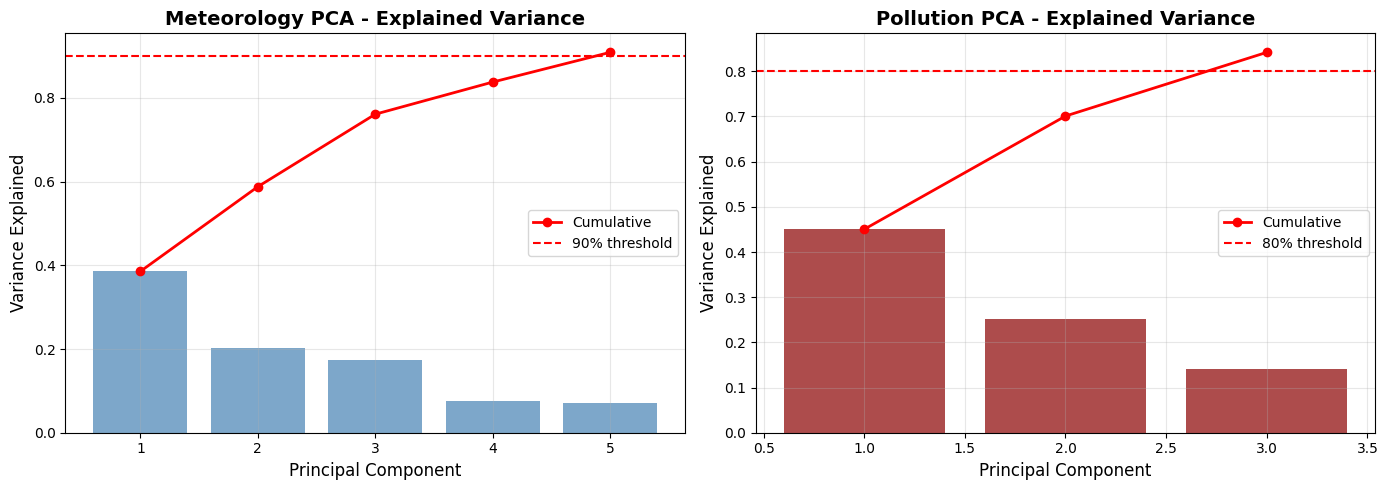

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# VARIANCE PLOTS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Meteorology
axes[0].bar(range(1, len(pca_met.explained_variance_ratio_) + 1), 
            pca_met.explained_variance_ratio_, 
            color='steelblue', alpha=0.7)
axes[0].plot(range(1, len(pca_met.explained_variance_ratio_) + 1), 
             np.cumsum(pca_met.explained_variance_ratio_), 
             'ro-', linewidth=2, label='Cumulative')
axes[0].axhline(y=0.9, color='red', linestyle='--', label='90% threshold')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variance Explained', fontsize=12)
axes[0].set_title('Meteorology PCA - Explained Variance', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Pollution
axes[1].bar(range(1, len(pca_pol.explained_variance_ratio_) + 1), 
            pca_pol.explained_variance_ratio_, 
            color='darkred', alpha=0.7)
axes[1].plot(range(1, len(pca_pol.explained_variance_ratio_) + 1), 
             np.cumsum(pca_pol.explained_variance_ratio_), 
             'ro-', linewidth=2, label='Cumulative')
axes[1].axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
axes[1].set_xlabel('Principal Component', fontsize=12)
axes[1].set_ylabel('Variance Explained', fontsize=12)
axes[1].set_title('Pollution PCA - Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pca_explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()

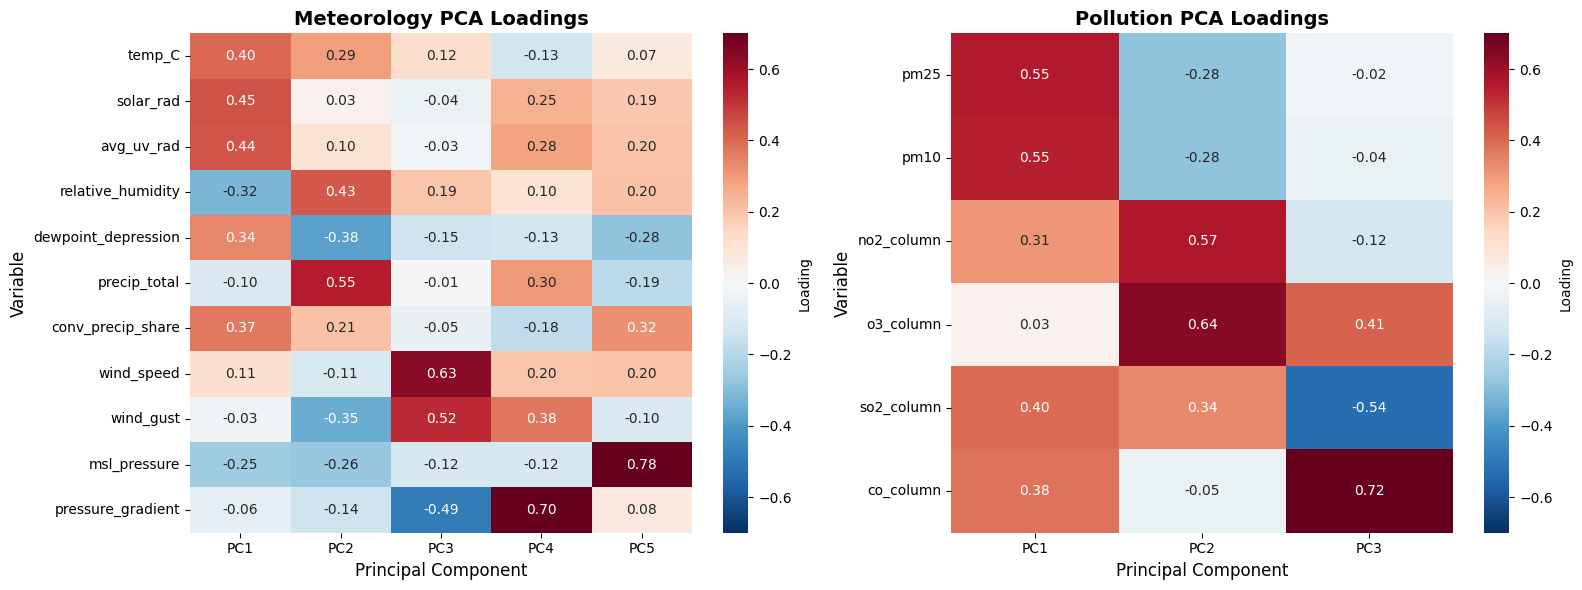

In [12]:
# LOADINGS HEATMAPS
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Meteorology Loadings
loadings_meteo = pd.DataFrame(
    pca_met.components_.T,
    index=meteo_vars,
    columns=[f"PC{i+1}" for i in range(pca_met.n_components_)]
)
sns.heatmap(loadings_meteo, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-0.7, vmax=0.7, ax=axes[0], 
            cbar_kws={'label': 'Loading'})
axes[0].set_title('Meteorology PCA Loadings', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variable', fontsize=12)

# Pollution Loadings
loadings_pollution = pd.DataFrame(
    pca_pol.components_.T,
    index=pollution_vars,
    columns=[f"PC{i+1}" for i in range(pca_pol.n_components_)]
)
sns.heatmap(loadings_pollution, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-0.7, vmax=0.7, ax=axes[1],
            cbar_kws={'label': 'Loading'})
axes[1].set_title('Pollution PCA Loadings', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Principal Component', fontsize=12)
axes[1].set_ylabel('Variable', fontsize=12)

plt.tight_layout()
plt.savefig('pca_loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

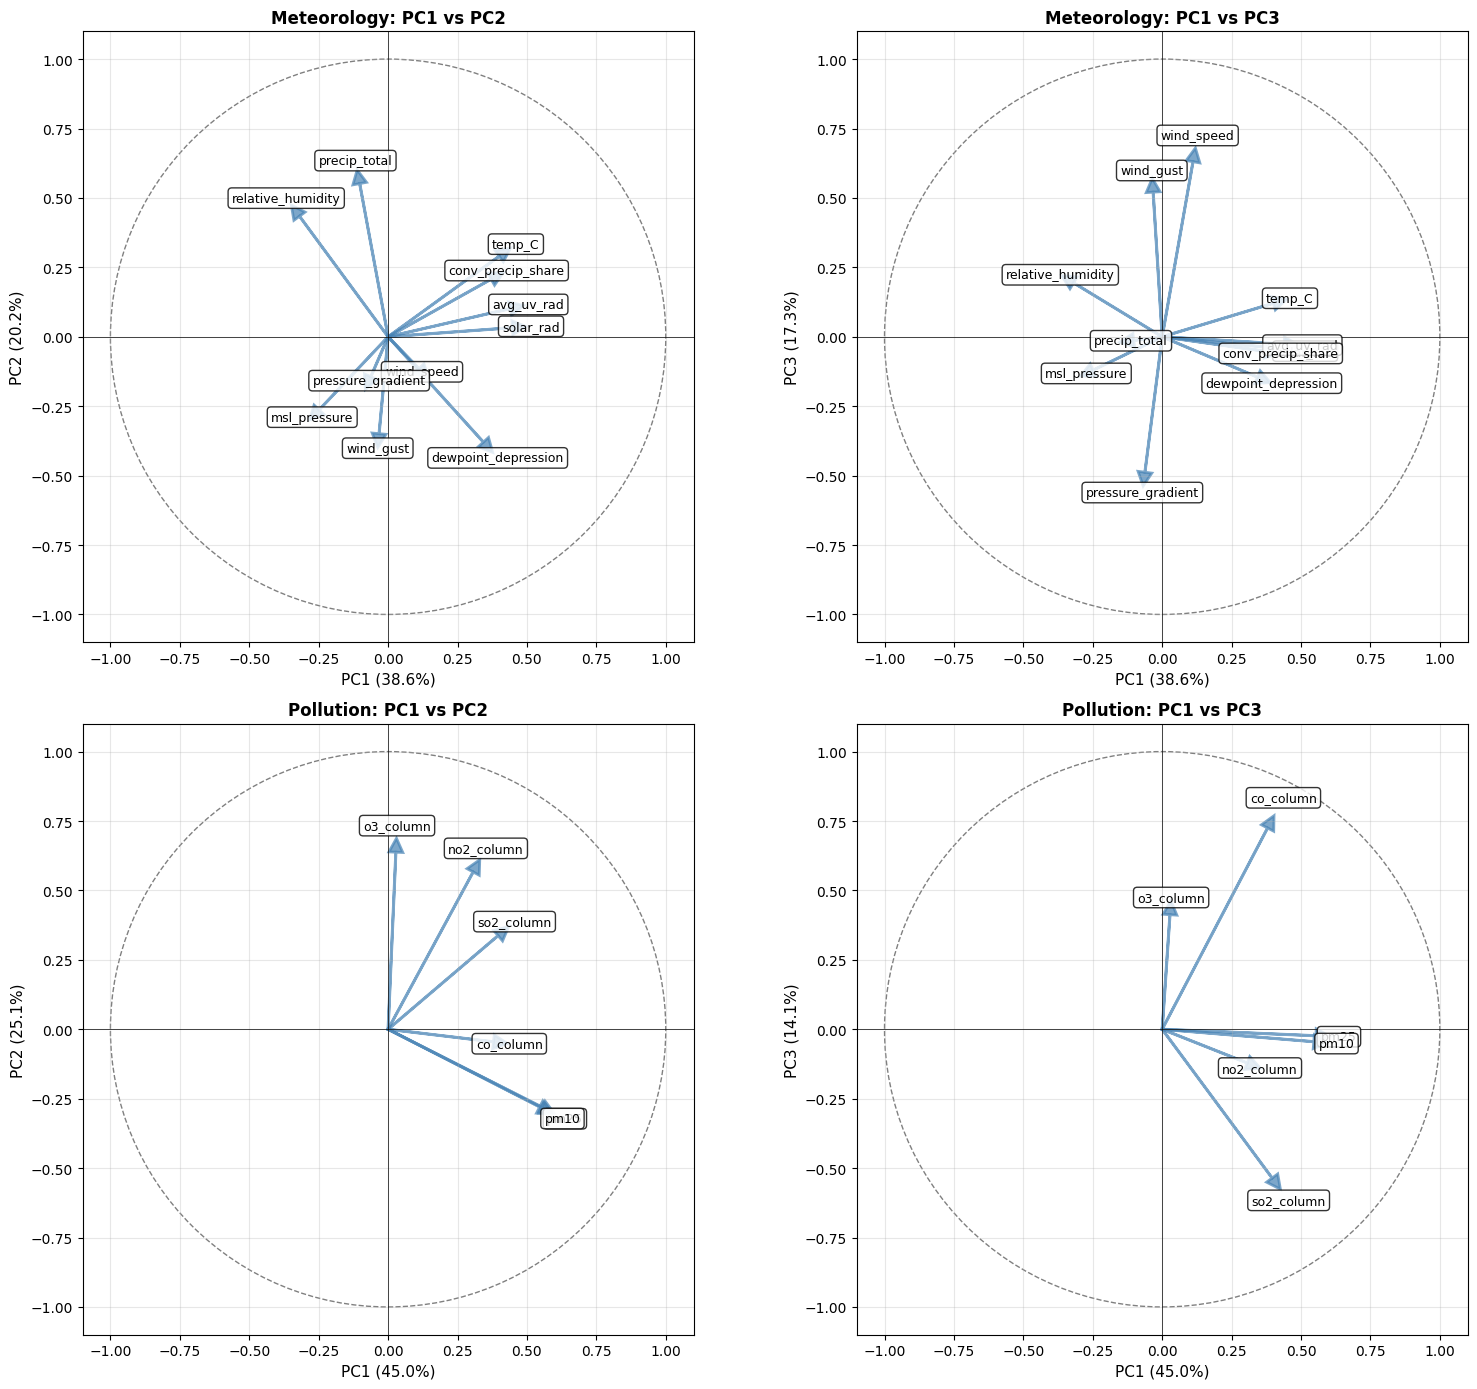

In [13]:
# CORRELATION CIRCLES 
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

def plot_correlation_circle(ax, loadings, pc_x, pc_y, var_explained, title):  # Plot correlation circle for two PCs
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1)
    ax.add_patch(circle)
    
    # Plot arrows for each variable
    for i, var in enumerate(loadings.index):
        x, y = loadings.iloc[i, pc_x], loadings.iloc[i, pc_y]
        ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.05, 
                fc='steelblue', ec='steelblue', alpha=0.7, linewidth=2)
        # Add labels with offset
        offset = 0.15 if abs(x) > 0.3 or abs(y) > 0.3 else 0.1
        ax.text(x * (1 + offset), y * (1 + offset), var, 
               fontsize=9, ha='center', va='center', 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_xlabel(f'PC{pc_x+1} ({var_explained[pc_x]:.1%})', fontsize=11)
    ax.set_ylabel(f'PC{pc_y+1} ({var_explained[pc_y]:.1%})', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')

# Meteorology: PC1 vs PC2
plot_correlation_circle(axes[0, 0], loadings_meteo, 0, 1, 
                       pca_met.explained_variance_ratio_,
                       'Meteorology: PC1 vs PC2')

# Meteorology: PC1 vs PC3
plot_correlation_circle(axes[0, 1], loadings_meteo, 0, 2, 
                       pca_met.explained_variance_ratio_,
                       'Meteorology: PC1 vs PC3')

# Pollution: PC1 vs PC2
plot_correlation_circle(axes[1, 0], loadings_pollution, 0, 1, 
                       pca_pol.explained_variance_ratio_,
                       'Pollution: PC1 vs PC2')

# Pollution: PC1 vs PC3
plot_correlation_circle(axes[1, 1], loadings_pollution, 0, 2, 
                       pca_pol.explained_variance_ratio_,
                       'Pollution: PC1 vs PC3')

plt.tight_layout()
plt.savefig('pca_correlation_circles.png', dpi=300, bbox_inches='tight')
plt.show()

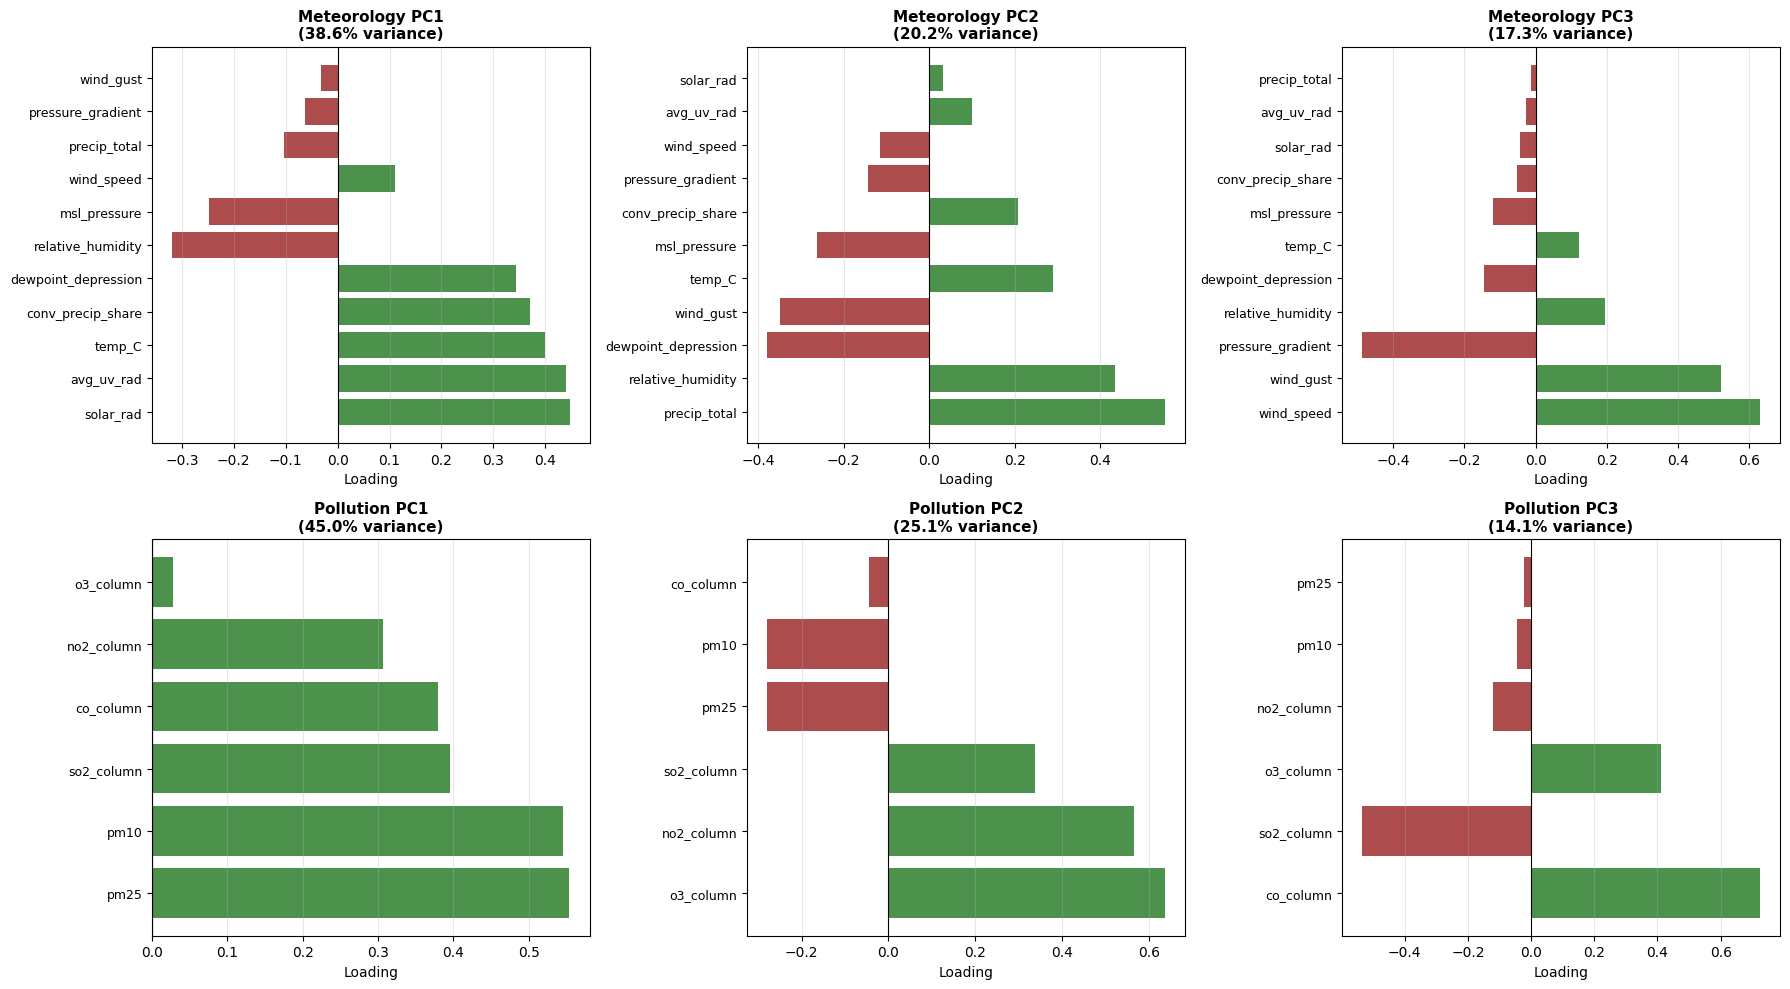

In [14]:
# TOP CONTRIBUTORS BAR PLOTS
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Meteorology - PC 1-3
for i in range(3):
    pc_loadings = loadings_meteo.iloc[:, i].sort_values(key=abs, ascending=False)
    colors = ['darkred' if x < 0 else 'darkgreen' for x in pc_loadings.values]
    
    axes[0, i].barh(range(len(pc_loadings)), pc_loadings.values, color=colors, alpha=0.7)
    axes[0, i].set_yticks(range(len(pc_loadings)))
    axes[0, i].set_yticklabels(pc_loadings.index, fontsize=9)
    axes[0, i].axvline(0, color='black', linewidth=0.8)
    axes[0, i].set_xlabel('Loading', fontsize=10)
    axes[0, i].set_title(f'Meteorology PC{i+1}\n({pca_met.explained_variance_ratio_[i]:.1%} variance)', 
                        fontsize=11, fontweight='bold')
    axes[0, i].grid(alpha=0.3, axis='x')

# Pollution - PC 1-3
for i in range(3):
    pc_loadings = loadings_pollution.iloc[:, i].sort_values(key=abs, ascending=False)
    colors = ['darkred' if x < 0 else 'darkgreen' for x in pc_loadings.values]
    
    axes[1, i].barh(range(len(pc_loadings)), pc_loadings.values, color=colors, alpha=0.7)
    axes[1, i].set_yticks(range(len(pc_loadings)))
    axes[1, i].set_yticklabels(pc_loadings.index, fontsize=9)
    axes[1, i].axvline(0, color='black', linewidth=0.8)
    axes[1, i].set_xlabel('Loading', fontsize=10)
    axes[1, i].set_title(f'Pollution PC{i+1}\n({pca_pol.explained_variance_ratio_[i]:.1%} variance)', 
                        fontsize=11, fontweight='bold')
    axes[1, i].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('pca_top_contributors.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# CLUSTERING

from sklearn.cluster import KMeans
 
df['decade'] = (df['year'] // 10) * 10

# Define PCs for clustering
pcs_for_clustering = ["PC_Met_1", "PC_Met_2", "PC_Met_3", "PC_Met_4", "PC_Met_5"]

# Create country-decade profiles (average monthly data within each decade)
df_country_decade = df.groupby(['country_name', 'decade'])[pcs_for_clustering].mean().reset_index()

# Perform decade-based clustering
optimal_k = 6  # optimal vaue
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=50)
df_country_decade['cluster'] = kmeans.fit_predict(df_country_decade[pcs_for_clustering])

print(f"Created {len(df_country_decade)} country-decade profiles")
print(f"Cluster distribution:\n{df_country_decade['cluster'].value_counts().sort_index()}\n")

# Merge back to monthly data
df = df.merge(
    df_country_decade[['country_name', 'decade', 'cluster']],
    on=['country_name', 'decade'],
    how='left'
)

print(f"✓ Cluster column added to monthly dataframe")
print(f"  Shape: {df.shape}")
print(f"  Missing clusters: {df['cluster'].isna().sum()}\n")


Created 905 country-decade profiles
Cluster distribution:
cluster
0    211
1    141
2    183
3     75
4    220
5     75
Name: count, dtype: int64

✓ Cluster column added to monthly dataframe
  Shape: (95568, 43)
  Missing clusters: 0



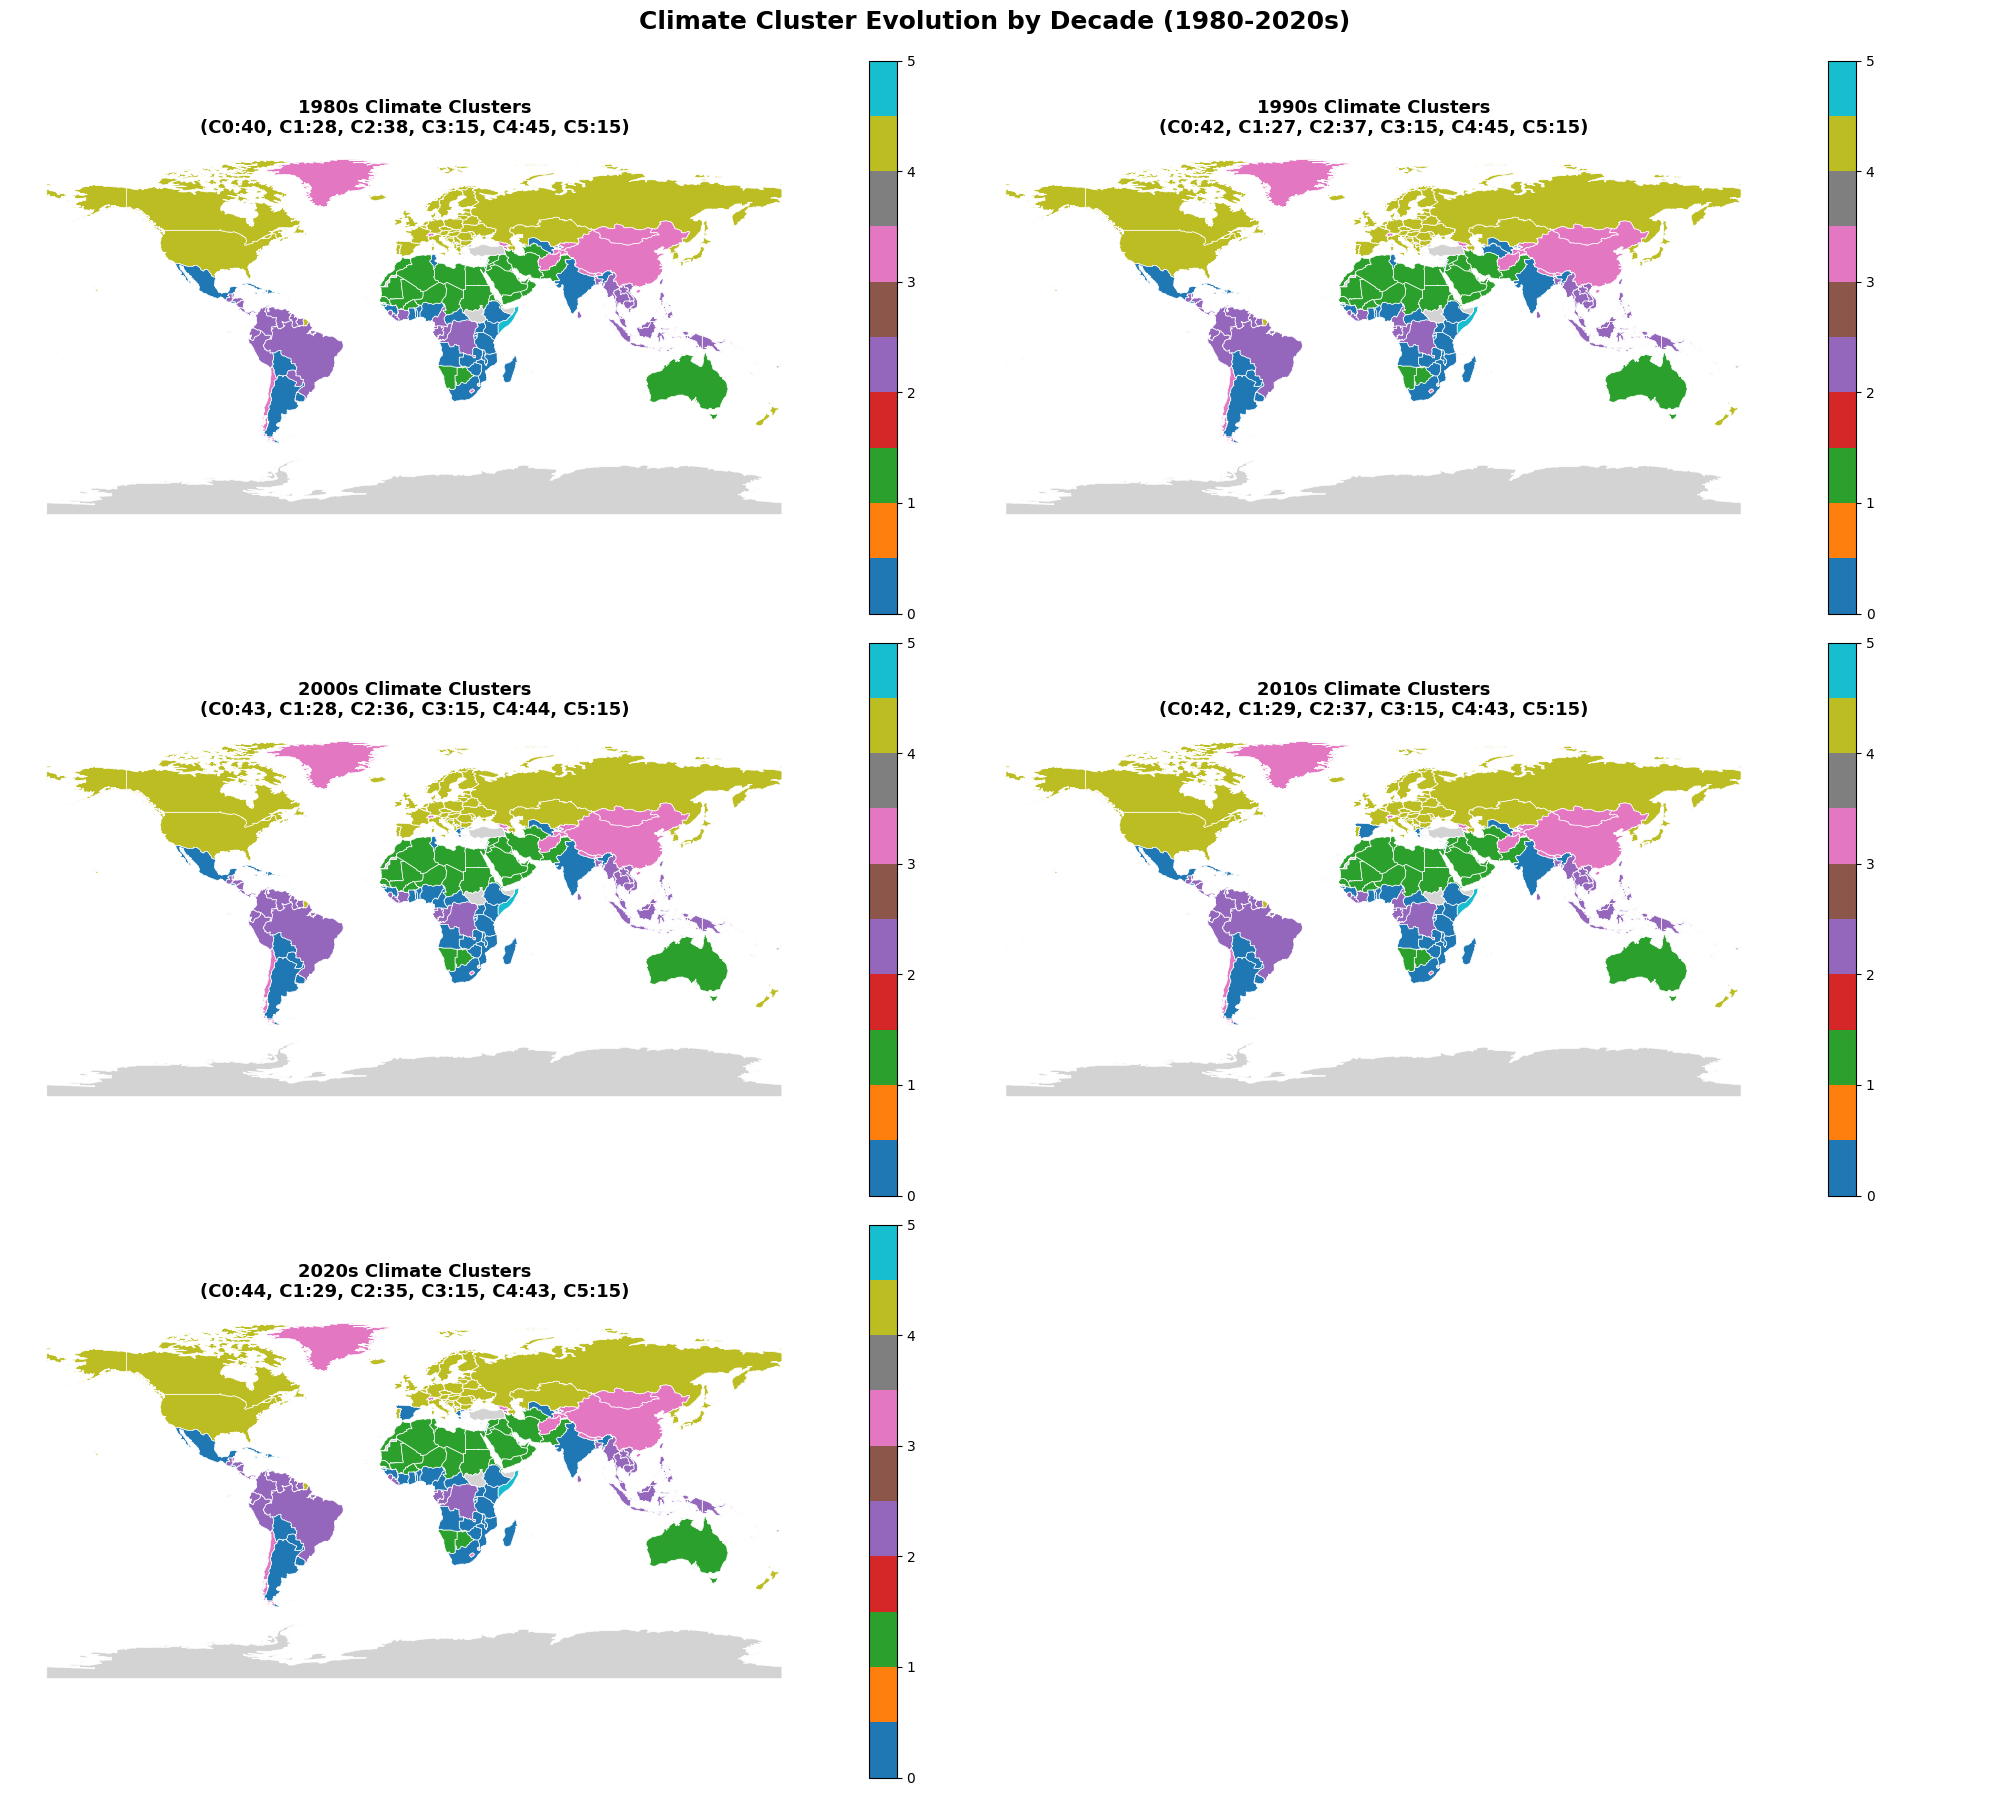

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# VISUALIZE EACH DECADE SEPARATELY

# Load world map
url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(url)
world = world.rename(columns={'NAME': 'name'})

name_map = {
    "United States": "United States of America",
    "United Kingdom": "United Kingdom",
    "Czech Republic": "Czechia",
    "Republic of Serbia": "Serbia",
    "North Macedonia": "North Macedonia",
    "Bosnia and Herzegovina": "Bosnia and Herz.",
    "Dominican Republic": "Dominican Rep.",
    "Equatorial Guinea": "Eq. Guinea",
    "Central African Republic": "Central African Rep.",
    "South Sudan": "S. Sudan",
    "Democratic Republic of the Congo": "Dem. Rep. Congo",
    "Republic of the Congo": "Congo",
    "Ivory Coast": "Côte d'Ivoire",
    "Swaziland": "eSwatini",
}

df_country_decade['country_name_mapped'] = df_country_decade['country_name'].replace(name_map)

# unique decades
decades = sorted(df_country_decade['decade'].unique())
n_decades = len(decades)

# subplot for each decade
n_cols = 2
n_rows = (n_decades + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
axes = axes.flatten() if n_decades > 1 else [axes]

for idx, decade in enumerate(decades):
    ax = axes[idx]
    
    df_decade = df_country_decade[df_country_decade['decade'] == decade]
    
    merged = world.merge(
        df_decade[['country_name_mapped', 'cluster']],
        left_on='name',
        right_on='country_name_mapped',
        how='left'
    )
    
    merged.plot(
        column='cluster',
        cmap='tab10',
        legend=True,
        missing_kwds={'color': 'lightgrey', 'label': 'No data'},
        edgecolor='white',
        linewidth=0.5,
        ax=ax,
        vmin=0,
        vmax=5,
        # legend_kwds={'loc': 'lower left', 'fontsize': 9}
    )
    
    # Count countries in each cluster for this decade
    cluster_counts = df_decade['cluster'].value_counts().sort_index()
    count_text = ', '.join([f"C{c}:{cnt}" for c, cnt in cluster_counts.items()])
    
    ax.set_title(f"{decade}s Climate Clusters\n({count_text})", 
                fontsize=13, fontweight='bold')
    ax.axis('off')

for idx in range(n_decades, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Climate Cluster Evolution by Decade (1980-2020s)', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('clusters_by_decade_all.png', dpi=300, bbox_inches='tight')
plt.show()


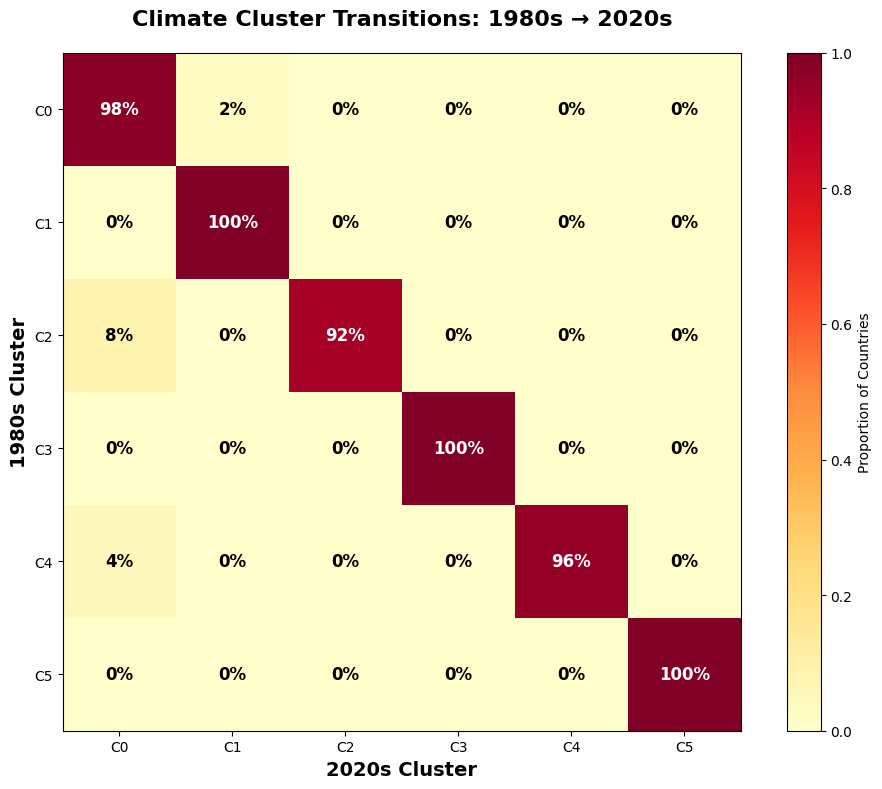


=== Countries that Changed Clusters (1980s → 2020s) ===
Total changed: 6 out of 181 (3.3%)

  Cameroon                       → C2 to C0
  Côte d'Ivoire                  → C2 to C0
  Greece                         → C4 to C0
  Paraguay                       → C2 to C0
  Spain                          → C4 to C0
  Tunisia                        → C0 to C1


In [17]:
# CLUSTER TRANSITION VISUALIZATION


decades = sorted(df_country_decade['decade'].unique())
n_decades = len(decades)

n_cols = 2
n_rows = (n_decades + n_cols - 1) // n_cols
# show how countries moved between clusters
if len(decades) >= 2:
    first_decade = decades[0]
    last_decade = decades[-1]
    
    df_first = df_country_decade[df_country_decade['decade'] == first_decade][['country_name', 'cluster']]
    df_last = df_country_decade[df_country_decade['decade'] == last_decade][['country_name', 'cluster']]
    
    transitions = df_first.merge(df_last, on='country_name', suffixes=(f'_{first_decade}', f'_{last_decade}'))
    
    transition_matrix = pd.crosstab(
        transitions[f'cluster_{first_decade}'], 
        transitions[f'cluster_{last_decade}'],
        normalize='index'
    )
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    im = ax.imshow(transition_matrix.values, cmap='YlOrRd', vmin=0, vmax=1)
    
    ax.set_xticks(range(len(transition_matrix.columns)))
    ax.set_yticks(range(len(transition_matrix.index)))
    ax.set_xticklabels([f'C{c}' for c in transition_matrix.columns])
    ax.set_yticklabels([f'C{c}' for c in transition_matrix.index])
    
    # Add percentage labels
    for i in range(len(transition_matrix.index)):
        for j in range(len(transition_matrix.columns)):
            value = transition_matrix.iloc[i, j]
            text_color = 'white' if value > 0.5 else 'black'
            ax.text(j, i, f'{value:.0%}', ha='center', va='center', 
                   color=text_color, fontsize=12, fontweight='bold')
    
    ax.set_xlabel(f'{last_decade}s Cluster', fontsize=14, fontweight='bold')
    ax.set_ylabel(f'{first_decade}s Cluster', fontsize=14, fontweight='bold')
    ax.set_title(f'Climate Cluster Transitions: {first_decade}s → {last_decade}s', 
                fontsize=16, fontweight='bold', pad=20)
    
    plt.colorbar(im, ax=ax, label='Proportion of Countries')
    plt.tight_layout()
    plt.savefig('cluster_transitions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # List countries that changed clusters
    changed = transitions[transitions[f'cluster_{first_decade}'] != transitions[f'cluster_{last_decade}']]
    print(f"\n=== Countries that Changed Clusters ({first_decade}s → {last_decade}s) ===")
    print(f"Total changed: {len(changed)} out of {len(transitions)} ({len(changed)/len(transitions)*100:.1f}%)\n")
    
    for _, row in changed.head(20).iterrows():
        print(f"  {row['country_name']:30s} → C{row[f'cluster_{first_decade}']} to C{row[f'cluster_{last_decade}']}")


In [18]:
seasonal_agg_dict = {
    # Temperature
    "temp_C": ["mean", "max", "min", "std"],
    
    # Precipitation
    "precip_total": ["sum", "max", "std"],
    
    # Humidity
    "relative_humidity": ["mean", "min"],
    
    # Pollution (key variables)
    "pm25": ["mean", "max"],
    "pm10": ["mean", "max"],
    "o3_column": ["mean", "max"],
    "no2_column": ["mean"],
    
    # Principal Components
    "PC_Met_1": ["mean", "max", "min"],  # Energy state 
    "PC_Met_2": ["mean", "max"],         # Moisture state
    "PC_Met_3": ["mean", "max"],         # Wind state
    "PC_Pol_1": ["mean", "max"],         # Pollution burden
    "PC_Pol_2": ["mean", "max"],         # Ozone 
    
    # Extremes
    "wind_gust": ["max", "mean"],
    "dewpoint_depression": ["mean", "max"],
    
    # Metadata
    "cluster": ["first"],
    "month": ["count"] 
}

# Aggregate to country-year-season level
df_seasonal = df.groupby(['country_name', 'year', 'season']).agg(seasonal_agg_dict)
df_seasonal.columns = ['_'.join(col).strip() for col in df_seasonal.columns.values]
df_seasonal = df_seasonal.reset_index()

print(f"Seasonal dataset shape: {df_seasonal.shape}")
print(f"Seasons: {df_seasonal['season'].unique()}")
print(f"Years: {df_seasonal['year'].min()} - {df_seasonal['year'].max()}")
print(f"\nSample of seasonal data:")
print(df_seasonal[['country_name', 'year', 'season', 'temp_C_mean', 'pm25_mean', 'PC_Met_1_mean']].head(12))

incomplete_seasons = df_seasonal[df_seasonal['month_count'] < 3]
df_seasonal = df_seasonal[df_seasonal['month_count'] == 3].copy()
print(f"\nSeasons with <3 months: {len(incomplete_seasons)} ({len(incomplete_seasons)/len(df_seasonal)*100:.1f}%)")


/tmp/ipykernel_28780/2327345515.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_seasonal = df.groupby(['country_name', 'year', 'season']).agg(seasonal_agg_dict)


Seasonal dataset shape: (31856, 36)
Seasons: ['autumn', 'spring', 'summer', 'winter']
Categories (4, object): ['autumn', 'spring', 'summer', 'winter']
Years: 1980 - 2023

Sample of seasonal data:
   country_name  year  season  temp_C_mean  pm25_mean  PC_Met_1_mean
0   Afghanistan  1980  autumn    13.093332        NaN       0.454658
1   Afghanistan  1980  spring    13.180226        NaN       1.350717
2   Afghanistan  1980  summer    23.906221        NaN       3.714479
3   Afghanistan  1980  winter    -0.137655        NaN      -2.179114
4   Afghanistan  1981  autumn    11.988902        NaN       0.490786
5   Afghanistan  1981  spring    13.207848        NaN       1.212856
6   Afghanistan  1981  summer    23.121204        NaN       3.501764
7   Afghanistan  1981  winter     0.655274        NaN      -2.251781
8   Afghanistan  1982  autumn    11.124735        NaN      -0.127881
9   Afghanistan  1982  spring    11.153059        NaN       0.828833
10  Afghanistan  1982  summer    23.062424   

In [19]:
# Winter severity index (cold + wet)
winter_data = df_seasonal[df_seasonal['season'] == 'winter'].copy()
winter_data['winter_severity'] = (
    -winter_data['temp_C_mean'] +  # Colder = higher score
    winter_data['precip_total_sum'] / 100  # Wetter = higher score
)

# Summer heat stress (hot + dry)
summer_data = df_seasonal[df_seasonal['season'] == 'summer'].copy()
summer_data['summer_heat_stress'] = (
    summer_data['temp_C_max'] * 
    (100 - summer_data['relative_humidity_min']) / 100
)

# Merge back
df_seasonal = df_seasonal.merge(
    winter_data[['country_name', 'year', 'winter_severity']], 
    on=['country_name', 'year'], 
    how='left'
)
df_seasonal = df_seasonal.merge(
    summer_data[['country_name', 'year', 'summer_heat_stress']], 
    on=['country_name', 'year'], 
    how='left'
)

print("Added seasonal indices:")
print("  - winter_severity: cold + precipitation index")
print("  - summer_heat_stress: heat + aridity index")

Added seasonal indices:
  - winter_severity: cold + precipitation index
  - summer_heat_stress: heat + aridity index


In [20]:
# Calculate Annual Metrics directly from the raw monthly 'df'
df_yearly_base = df.groupby(['country_name', 'year']).agg({
    # Climate Variables
    "temp_C": ["mean", "max", "min", "std"],
    "precip_total": ["sum", "max", "std"],
    "relative_humidity": ["mean", "min"],
    
    # Pollution Variables
    "pm25": ["mean", "max", "std"],
    "pm10": ["mean", "max"],
    "o3_column": ["mean", "max"],
    "no2_column": ["mean", "max"],
    "so2_column": ["mean"],
    "co_column": ["mean"],
    
    # Principal Components
    "PC_Met_1": ["mean", "max", "min"],
    "PC_Met_2": ["mean", "max"],
    "PC_Met_3": ["mean", "max"],
    "PC_Met_4": ["mean"],
    "PC_Met_5": ["mean"],
    "PC_Pol_1": ["mean", "max"],
    "PC_Pol_2": ["mean", "max"],
    "PC_Pol_3": ["mean"],
    
    # Extremes and Stability
    "wind_gust": ["max", "mean"],
    "dewpoint_depression": ["mean", "max"],
    "temp_skin_minus_air": ["mean", "std"],
    
    "cluster": lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
    "month": "count"
})

df_yearly_base.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_yearly_base.columns.values]
df_yearly_base = df_yearly_base.reset_index().rename(columns={'cluster_first': 'cluster'})

# Extract ONLY necessary seasonal columns from df_seasonal
df_seasonal_subset = df_seasonal.pivot_table(
    index=['country_name', 'year'],
    columns='season',
    values=['temp_C_mean', 'precip_total_sum', 'winter_severity', 'summer_heat_stress'],
    aggfunc='mean',
    observed=False
)
df_seasonal_subset.columns = ['_'.join(col).strip() for col in df_seasonal_subset.columns.values]
df_seasonal_subset = df_seasonal_subset.reset_index()

# Final merge
df_yearly_final = df_yearly_base.merge(
    df_seasonal_subset,
    on=['country_name', 'year'],
    how='left'
)

print(f"Yearly dataset shape: {df_yearly_final.shape}")
print(f"Total variables: {len(df_yearly_final.columns)}")

Yearly dataset shape: (7964, 60)
Total variables: 60


In [21]:
## MINOR CHANGES
df_yearly_final.rename(columns={'cluster_<lambda>': 'cluster'}, inplace=True)

# We only want 'winter_severity' for winter, and 'summer_heat_stress' for summer
cols_to_drop = [c for c in df_yearly_final.columns if 
                ('winter_severity' in c and 'winter' not in c) or 
                ('summer_heat_stress' in c and 'summer' not in c)]

df_yearly_final.drop(columns=cols_to_drop, inplace=True)

print(f"Final shape: {df_yearly_final.shape}")
df_yearly_final.to_csv("Climate_Data_Yearly_Final.csv", index=False)
df_seasonal.to_csv("Climate_Data_Seasonal.csv", index=False)


Final shape: (7964, 60)
